In [1]:
import pickle as pk
import pandas as pd
from tqdm import tqdm
from pymatgen.core.structure import Structure, Molecule
from megnet.models import MEGNetModel
from megnet.data.crystal import CrystalGraph
import numpy as np

In [15]:
data = pd.read_csv('data/data_all_new.csv')

molecules = []

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    molecules.append((Molecule.from_str(row['xyz'], 'xyz'), row['U_0']))

100%|██████████| 122381/122381 [01:03<00:00, 1915.84it/s]


In [65]:
def create_structure_dict(structures: list):
    structure_dict = {}

    for structure in tqdm(structures):
        if structure[0].formula in structure_dict:
            structure_dict[structure[0].formula].append(structure)
        else:
            structure_dict[structure[0].formula] = [structure]
        
    return structure_dict

In [66]:
structure_dict = create_structure_dict(molecules)

100%|██████████| 122381/122381 [00:13<00:00, 8755.02it/s]


In [57]:
from sklearn.model_selection import train_test_split

def train_test_split_for_structures(structure_dict: dict, test_size: float = 0.1):
    structures_train, structures_test = [], []
    targets_train, targets_test = [], []

    for _, data in tqdm(structure_dict.items()):
        if len(data) < 2:
            train_struct, train_target = zip(*data)
            structures_train.append(train_struct)
            targets_train.append(train_target)
        else:
            train_data, test_data = train_test_split(data, test_size=test_size, random_state=42)
            
            train_struct, train_target = zip(*train_data)
            structures_train += train_struct
            targets_train += train_target
            
            test_struct, test_target = zip(*test_data)
            structures_test += test_struct
            targets_test += test_target
        
    
    return structures_train, targets_train, structures_test, targets_test


In [58]:
molecules_train, targets_train, molecules_val_test, targets_val_test = train_test_split_for_structures(structure_dict)

  0%|          | 0/134 [00:00<?, ?it/s]

100%|██████████| 134/134 [00:00<00:00, 988.32it/s]


In [63]:
structure_dict_val_test = create_structure_dict(zip(molecules_val_test, targets_val_test))

In [67]:
molecules_val, targets_val, moleculas_test, targets_test = train_test_split_for_structures(structure_dict_val_test)

100%|██████████| 117/117 [00:00<00:00, 3352.55it/s]


In [4]:
nfeat_bond = 10
r_cutoff = 5
gaussian_centers = np.linspace(0, r_cutoff + 1, nfeat_bond)
gaussian_width = 0.5
graph_converter = CrystalGraph(cutoff=r_cutoff)
model = MEGNetModel(graph_converter=graph_converter, centers=gaussian_centers, width=gaussian_width)

# Model training
# Here, `structures` is a list of pymatgen Structure objects.
# `targets` is a corresponding list of properties.

d:\Projects\projects_python\m3gnet_tests\.venv\lib\site-packages\keras\initializers\initializers_v2.py:121: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [5]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

loss_values = []

class LossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_values.append(logs.get('loss'))

log_dir = "logs/fit"  # Путь для сохранения журналов TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_images=True, update_freq = 'epoch')

history = LossHistory()

model.train(train_structures=molecules_train,
            train_targets=targets_train,
            validation_structures=molecules_val,
            validation_targets=targets_val,
            epochs=10,
            batch_size=128,
            callbacks=[history, tensorboard_callback])

Epoch 1/100
861/861 [==============================] - 220s 233ms/step - loss: 11917.7441
Epoch 2/100
861/861 [==============================] - 198s 230ms/step - loss: 892.0065
Epoch 3/100
861/861 [==============================] - 198s 230ms/step - loss: 581.4110
Epoch 4/100
861/861 [==============================] - 198s 230ms/step - loss: 519.1967
Epoch 5/100
861/861 [==============================] - 198s 230ms/step - loss: 449.5564
Epoch 6/100
861/861 [==============================] - 198s 230ms/step - loss: 440.8917
Epoch 7/100
861/861 [==============================] - 196s 228ms/step - loss: 330.2442
Epoch 8/100
861/861 [==============================] - 194s 225ms/step - loss: 329.6953
Epoch 9/100
861/861 [==============================] - 198s 230ms/step - loss: 278.7936
Epoch 10/100
861/861 [==============================] - 198s 230ms/step - loss: 343.2840
Epoch 11/100
861/861 [==============================] - 198s 230ms/step - loss: 279.9263
Epoch 12/100
861/861 [======

In [6]:
model.save_model('models/100_e_default.hdf5')

In [5]:
import plotly.graph_objects as go
import numpy as np
import tensorflow as tf

# Создайте список для хранения значений функции потерь
loss_values = []

# Создайте функцию обратного вызова для записи значений функции потерь
class LossHistory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_values.append(logs.get('loss'))  # Добавляем значение функции потерь в список
        update_plot(epoch+1)  # Обновляем график

# Создайте экземпляр функции обратного вызова
history = LossHistory()

# Создайте функцию для обновления графика
def update_plot(num_epochs):
    fig = go.Figure(data=go.Scatter(y=loss_values, mode='lines'))
    fig.update_layout(title='Loss Function', xaxis_title='Epoch', yaxis_title='Loss')
    fig.show()

model.train(molecules_train, targets_train, epochs=10, callbacks=[history])

Epoch 1/10
8/8 [==============================] - ETA: 0s - loss: 117799.6094

8/8 [==============================] - 20s 261ms/step - loss: 117799.6094
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 110373.2031

8/8 [==============================] - 2s 243ms/step - loss: 110373.2031
Epoch 3/10
8/8 [==============================] - ETA: 0s - loss: 76787.6562

8/8 [==============================] - 2s 275ms/step - loss: 76787.6562
Epoch 4/10
8/8 [==============================] - ETA: 0s - loss: 217253.8281

8/8 [==============================] - 2s 270ms/step - loss: 217253.8281
Epoch 5/10
8/8 [==============================] - ETA: 0s - loss: 24479.3652

8/8 [==============================] - 2s 242ms/step - loss: 24479.3652
Epoch 6/10
7/8 [=========================>....] - ETA: 0s - loss: 23581.3027

8/8 [==============================] - 2s 236ms/step - loss: 25450.2461
Epoch 7/10
8/8 [==============================] - ETA: 0s - loss: 21359.0352

8/8 [==============================] - 2s 226ms/step - loss: 21359.0352
Epoch 8/10
8/8 [==============================] - ETA: 0s - loss: 25012.7461

8/8 [==============================] - 2s 246ms/step - loss: 25012.7461
Epoch 9/10
8/8 [==============================] - ETA: 0s - loss: 22743.1758

8/8 [==============================] - 2s 254ms/step - loss: 22743.1758
Epoch 10/10
8/8 [==============================] - ETA: 0s - loss: 26553.1445

8/8 [==============================] - 2s 238ms/step - loss: 26553.1445


In [7]:
y_pred = []
y_true = []
mae = 0

for i in tqdm(range(len(molecules_valid))):
    prediction = model.predict_structure(molecules_valid[i])
    y_pred.append(prediction)
    true_value = targets_valid[i]
    y_true.append(true_value)
    mae += abs(true_value - prediction)
mae /= len(molecules_valid)
mae

100%|██████████| 12239/12239 [11:54<00:00, 17.13it/s]


array([7.3001375], dtype=float32)

In [13]:
len(molecules_valid)

12239

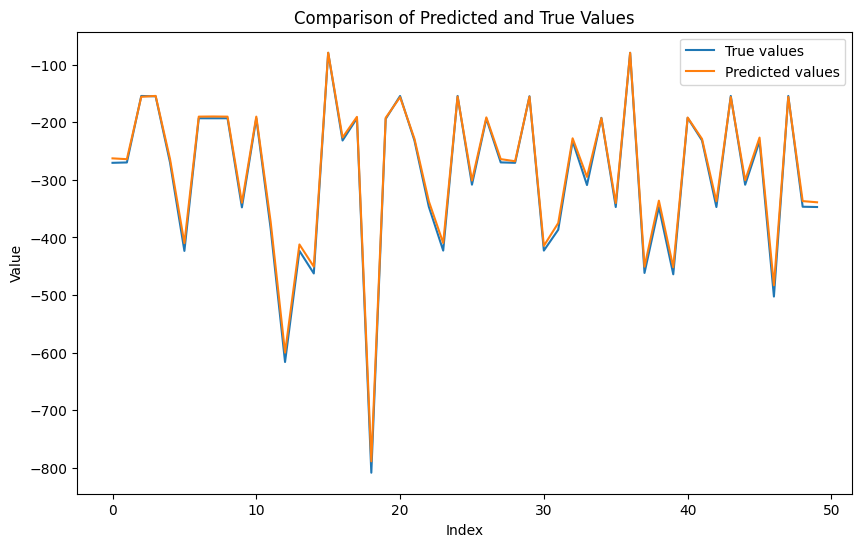

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_true[:50], label='True values')
plt.plot(y_pred[:50], label='Predicted values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Predicted and True Values')
plt.legend();

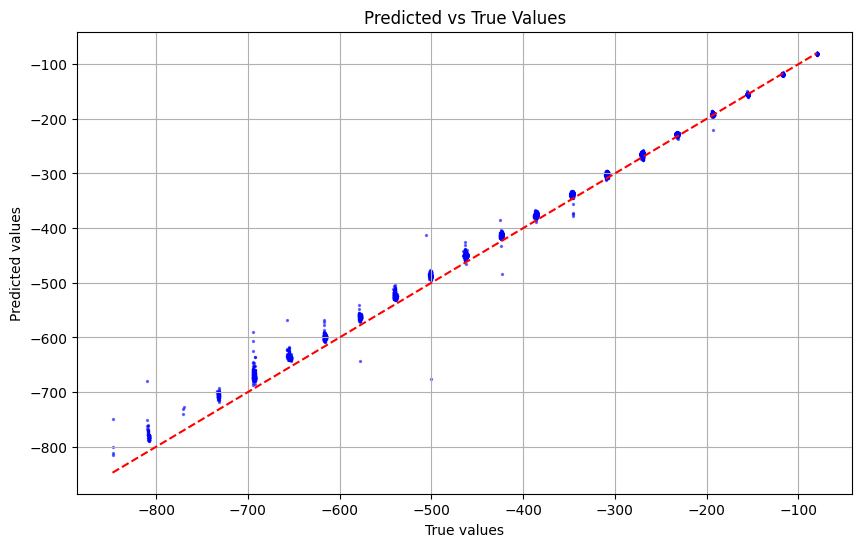

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, color='b', alpha=0.5, s=2) 
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='r', linestyle='--')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs True Values')
plt.grid(True)

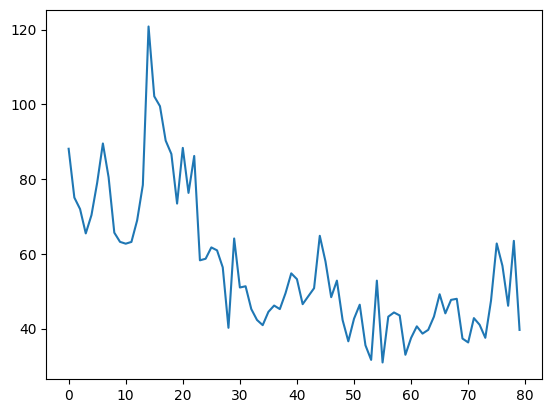

In [11]:
plt.plot(loss_values[20:])

In [ ]:
model.save_model('models/100_e_default.hdf5')

In [18]:
model = MEGNetModel(graph_converter=graph_converter, centers=gaussian_centers, width=gaussian_width)
graphs_valid = []
targets_valid = []
structures_invalid = []
for s, p in zip(molecules, targets):
    try:
        graph = model.graph_converter.convert(s)
        graphs_valid.append(graph)
        targets_valid.append(p)
    except:
        structures_invalid.append(s)

# train the model using valid graphs and targets
model.train_from_graphs(graphs_valid, targets_valid, epochs=10)

Epoch 1/10
8/8 [==============================] - 21s 340ms/step - loss: 119846.7109
Epoch 2/10
8/8 [==============================] - 3s 340ms/step - loss: 119253.7344
Epoch 3/10
8/8 [==============================] - 3s 346ms/step - loss: 85360.1094
Epoch 4/10
8/8 [==============================] - 3s 346ms/step - loss: 672155.0000
Epoch 5/10
8/8 [==============================] - 3s 331ms/step - loss: 109076.1016
Epoch 6/10
8/8 [==============================] - 3s 337ms/step - loss: 30412.1992
Epoch 7/10
8/8 [==============================] - 3s 352ms/step - loss: 25225.9336
Epoch 8/10
8/8 [==============================] - 3s 334ms/step - loss: 23487.7695
Epoch 9/10
8/8 [==============================] - 3s 350ms/step - loss: 21019.4512
Epoch 10/10
8/8 [==============================] - 3s 365ms/step - loss: 19996.2676
